# Main script to run iGFA

In [1]:
import os
import sys
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyomo.environ as pyo
from pyomo.contrib.iis import compute_infeasibility_explanation
warnings.filterwarnings("ignore", "use_inf_as_na")  # Generated by seaborn

In [2]:
sys.path.insert(0, '/home/cabsel/gfa/')
from gfapy.model import summarize_instance
from gfapy.plotter import plot_fig, plot_meas, plot_perturb
from gfapy.igfa_fitflux import parse_model, res_plotter

/home/cabsel/gfa/gfapy/model.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
mainDir = '/home/cabsel/gfa/'
inputDir = os.path.join(mainDir, 'inputfiles')

## Read GFA model from Excel

In [4]:
rxn_models = pd.read_excel(os.path.join(inputDir, 'Lee et al', 'Leeetal_model.xlsx'), sheet_name=None)
stoich_data = rxn_models['Stoichiometry'].iloc[1:, :].set_index("Glycoforms")
rxn_meta = rxn_models['Enzyme-Reaction Relations'].set_index("Reaction ID")

met_meta_cols = sorted(set(stoich_data.columns) - set(rxn_meta.index))
met_meta = stoich_data[met_meta_cols].copy()
stoich_data = stoich_data.drop(columns=met_meta_cols)

display(stoich_data)
display(met_meta)
display(rxn_meta)

Ent_Man7  Ex_Man7  Ex_Man6  Ex_Man5  Ex_G0-GlcNAc  Ex_G0  Ex_G0F  \
Glycoforms                                                                     
Man7             1.0     -1.0      0.0      0.0           0.0    0.0     0.0   
Man6             0.0      0.0     -1.0      0.0           0.0    0.0     0.0   
Man5             0.0      0.0      0.0     -1.0           0.0    0.0     0.0   
G0-GlcNAc        0.0      0.0      0.0      0.0          -1.0    0.0     0.0   
G0               0.0      0.0      0.0      0.0           0.0   -1.0     0.0   
G0F              0.0      0.0      0.0      0.0           0.0    0.0    -1.0   
G0F-GlcNAc       0.0      0.0      0.0      0.0           0.0    0.0     0.0   
G0F+GlcNAc       0.0      0.0      0.0      0.0           0.0    0.0     0.0   
G1a/b            0.0      0.0      0.0      0.0           0.0    0.0     0.0   
G1Fa/b           0.0      0.0      0.0      0.0           0.0    0.0     0.0   
G2F              0.0      0.0      0.0      0.0           0.0    0.0     0.0   
A1G1F            0.0      0.0      0.0      0.0           0.0    0.0     0.0   
A1G2F            0.0      0.0      0.0      0.0           0.0    0.0     0.0   

            Ex_G0F-GlcNAc  Ex_G0F+GlcNAc  Ex_G1a/b  ...  R8  R6  R7  R9 R10  \
Glycoforms                                          ...                       
Man7                  0.0            0.0       0.0  ...   0   0   0   0   0   
Man6                  0.0            0.0       0.0  ...   0   0   0   0   0   
Man5                  0.0            0.0       0.0  ...   0   0   0   0   0   
G0-GlcNAc             0.0            0.0       0.0  ...   0   0  -1   0   0   
G0                    0.0            0.0       0.0  ...   0  -1   0   0  -1   
G0F                   0.0            0.0       0.0  ...  -1   1   0   0   0   
G0F-GlcNAc           -1.0            0.0       0.0  ...   0   0   1   0   0   
G0F+GlcNAc            0.0           -1.0       0.0  ...   1   0   0   0   0   
G1a/b                 0.0            0.0      -1.0  ...   0   0   0  -1   1   
G1Fa/b                0.0            0.0       0.0  ...   0   0   0   1   0   
G2F                   0.0            0.0       0.0  ...   0   0   0   0   0   
A1G1F                 0.0            0.0       0.0  ...   0   0   0   0   0   
A1G2F                 0.0            0.0       0.0  ...   0   0   0   0   0   

           R11 R12 R13 R14 R15  
Glycoforms                      
Man7         0   0   0   0   0  
Man6         0   0   0   0   0  
Man5         0   0   0   0   0  
G0-GlcNAc    0   0   0   0   0  
G0           0   0   0   0   0  
G0F         -1   0   0   0   0  
G0F-GlcNAc   0   0   0   0   0  
G0F+GlcNAc   0   0   0   0   0  
G1a/b        0   0   0   0   0  
G1Fa/b       1  -1   0  -1   0  
G2F          0   1   0   0  -1  
A1G1F        0   0  -1   1   0  
A1G2F        0   0   1   0   1  

[13 rows x 29 columns]

Compartments                                          Structure
Glycoforms                                                                 
Man7           cis_golgi  {Man(1-?)}{Man(2-?)}Man(?)[Man(?)]Man(?)[Man(?...
Man6           cis_golgi  {Man(1-?)}Man(?)[Man(?)]Man(?)[Man(?)]Man(?)Gl...
Man5           cis_golgi  Man(?)[Man(?)]Man(?)[Man(?)]Man(?)GlcNAc(?)GlcNAc
G0-GlcNAc   medial_golgi       Man(?)[GlcNAc(?)Man(?)]Man(?)GlcNAc(?)GlcNAc
G0          medial_golgi  GlcNAc(?)Man(?)[GlcNAc(?)Man(?)]Man(?)GlcNAc(?...
G0F         medial_golgi  GlcNAc(?)Man(?)[GlcNAc(?)Man(?)]Man(?)GlcNAc(?...
G0F-GlcNAc  medial_golgi  Man(?)[GlcNAc(?)Man(?)]Man(?)GlcNAc(?)[Fuc(?)]...
G0F+GlcNAc  medial_golgi  GlcNAc(?)[GlcNAc(?)]Man(?)[GlcNAc(?)Man(?)]Man...
G1a/b        trans Golgi  {Gal(1-?)}GlcNAc(?)Man(?)[GlcNAc(?)Man(?)]Man(...
G1Fa/b       trans Golgi  {Gal(1-?)}GlcNAc(?)Man(?)[GlcNAc(?)Man(?)]Man(...
G2F          trans Golgi  Gal(?)GlcNAc(?)Man(?)[Gal(?)GlcNAc(?)Man(?)]Ma...
A1G1F        trans Golgi  {Neu5Ac(1-?)Gal()}GlcNAc(?)Man(?)[GlcNAc(?)Man...
A1G2F        trans Golgi  {Neu5Ac(1-?)}Gal(?)GlcNAc(?)Man(?)[Gal(?)GlcNA...

Reaction Description     Enzymes  \
Reaction ID                                                                    
Ent_Man7                                           Entry of Man7         NaN   
Ex_Man7                                        Secretion of Man7         NaN   
Ex_Man6                                        Secretion of Man6         NaN   
Ex_Man5                                        Secretion of Man5         NaN   
Ex_G0-GlcNAc                              Secretion of G0-GlcNAc         NaN   
Ex_G0                                            Secretion of G0         NaN   
Ex_G0F                                          Secretion of G0F         NaN   
Ex_G0F-GlcNAc                            Secretion of G0F-GlcNAc         NaN   
Ex_G0F+GlcNAc                            Secretion of G0F+GlcNAc         NaN   
Ex_G1a/b                                      Secretion of G1a/b         NaN   
Ex_G1Fa/b                                    Secretion of G1Fa/b         NaN   
Ex_G2F                                          Secretion of G2F         NaN   
Ex_A1G1F                                      Secretion of A1G1F         NaN   
Ex_A1G2F                                      Secretion of A1G2F         NaN   
R1                                          Man7 trimmed to Man6        ManI   
R2                                         Man 6 trimmed to Man5        ManI   
R3             Man5 undergoes trimming and GlcNAc addition to...  GnTI/ManII   
R4                                    GlcNAc addition to form G0       GnTII   
R5                                   GlcNAc addition to form G0F       GnTII   
R8                            GlcNAc addition to form G0F+GlcNAc       GnTIV   
R6                                     Fucosylation of N-glycans        FucT   
R7                                     Fucosylation of N-glycans        FucT   
R9                                     Fucosylation of N-glycans        FucT   
R10                                          Galactose addition         GalT   
R11                                          Galactose addition         GalT   
R12                                          Galactose addition         GalT   
R13                                          Galactose addition         GalT   
R14                                              Neu5Ac addition        SiaT   
R15                                              Neu5Ac addition        SiaT   

                           Enzyme Name                                 Notes  \
Reaction ID                                                                    
Ent_Man7                           NaN                                   NaN   
Ex_Man7                            NaN                                   NaN   
Ex_Man6                            NaN                                   NaN   
Ex_Man5                            NaN                                   NaN   
Ex_G0-GlcNAc                       NaN                                   NaN   
Ex_G0                              NaN                                   NaN   
Ex_G0F                             NaN                                   NaN   
Ex_G0F-GlcNAc                      NaN                                   NaN   
Ex_G0F+GlcNAc                      NaN                                   NaN   
Ex_G1a/b                           NaN                                   NaN   
Ex_G1Fa/b                          NaN                                   NaN   
Ex_G2F                             NaN                                   NaN   
Ex_A1G1F                           NaN                                   NaN   
Ex_A1G2F                           NaN                                   NaN   
R1                         Mannosidase                                   NaN   
R2                         Mannosidase                                   NaN   
R3                    Multiple enzymes       MGAT1 followed by MAN2A1/MAN2A2   
R4             Glucosaminyltransferase     

## Read and format data 

In [5]:
pH_scale = 'highpH'

In [6]:
expt_data = pd.read_excel(os.path.join(inputDir, 'Lee et al', pH_scale+'_processed.xlsx'), sheet_name=None, index_col=0)
expt_data['q_prod'].loc[13, :] = expt_data['q_prod'].loc[12, :]
expt_data['q_prod'] = expt_data['q_prod'].drop(index=[12, 14])
expt_data['Fractions'].loc[13, :] = expt_data['Fractions'].loc[[12, 14], :].mean()
expt_data['Fractions'] = expt_data['Fractions'].drop(index=[12, 14])
expt_data['fit_Fractions'] = expt_data['fit_Concentrations'].div(expt_data['Titer']['Titer (g/L)'], axis=0)

<b> Comments: </b> Multiply titer with 1000 for unit consistency 
$$
v_{E, i}(t) = \frac{1}{VCD(t)} \cdot \frac{dfrac_{i}(t) \cdot C_{mAb}(t)}{dt} + frac_{i}(t) \cdot \left (Q_{prod}(t) - \frac{dC_{mAB}(t)}{dt} \cdot \frac{1}{VCD}\right)\\
$$

In [7]:
dtiter_VCD = (expt_data['Titer']['diff_Titer (g/L)'].div(expt_data['VCD']['VCD (1E6 VC/mL)']))*1000
secondterm = (expt_data['Fractions'].
              mul(expt_data['q_prod']['Spec Prod (pg/cells/day)'] - dtiter_VCD[expt_data['q_prod'].index], axis=0).
              dropna())
dC_VCD = (expt_data['diff_Concentrations'].div(expt_data['VCD']['VCD (1E6 VC/mL)'], axis=0).dropna())*1000
expt_data['Secreted Flux'] = dC_VCD.loc[expt_data['q_prod'].index, :] + secondterm
display(expt_data.keys())

dict_keys(['VCD', 'Titer', 'Fractions', 'q_prod', 'Concentrations', 'fit_Concentrations', 'diff_Concentrations', 'fit_Fractions', 'Secreted Flux'])

/home/cabsel/miniconda3/envs/Shri/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/cabsel/miniconda3/envs/Shri/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/cabsel/miniconda3/envs/Shri/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/cabsel/miniconda3/envs/Shri/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


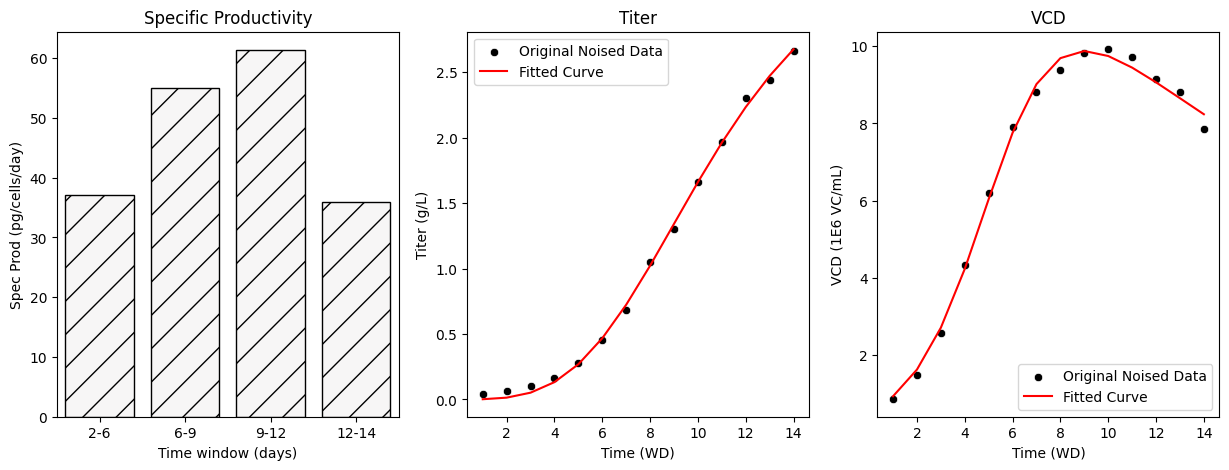

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=expt_data['q_prod'], x='Time window (days)', y='Spec Prod (pg/cells/day)', ax=ax[0], facecolor='#F7F6F6', edgecolor='k', hatch='/', fill=True)
ax[0].set_title('Specific Productivity')
plot_fig(time_col='Time (WD)', data=expt_data['Titer'], meas_col='Titer (g/L)', smooth_col='fit_Titer (g/L)', ax=ax[1])
ax[1].set_title('Titer')
plot_fig(time_col='Time (WD)', data=expt_data['VCD'], meas_col='VCD (1E6 VC/mL)', smooth_col='fit_VCD (1E6 VC/mL)', ax=ax[2])
ax[2].set_title('VCD')
plt.show()

## Initialize iGFA and ingest experimental measurements into iGFA's class

In [9]:
linear_rxns = ['R1', 'R2', 'R3']  # 'R1', 'R2', 'R3', 'R4', 'R5', 'R8', 'R6', 'R7', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15'
init_model = parse_model(stoich_data, rxn_meta, met_meta, 1, linear_rxns)

In [10]:
init_model.read_measurements(expt_data, time_col_name='Time (WD)')
data = init_model.fetch_data(spec_prod_col='Spec Prod (pg/cells/day)') 
# Use get_diff=True only when derivative of fractions is precalculated
print(data[None].keys())

dict_keys(['timepoints', 'timepoints_data', 'spec_prod', 'secreted_flux_data'])


In [11]:
data[None]['reg_param'] = {None: 100}

In [12]:
model = init_model.create_pyomomodel(fit_beta=True, regularize_params=True)  # Use precalc_diff only when derivative of fractions is precalculated
instance = model.create_instance(data=data)
# discretizer = pyo.TransformationFactory('dae.finite_difference')
# discretizer.apply_to(instance, nfe=3, wrt=model.timepoints, scheme='CENTRAL')
summarize_instance(instance)

number_of_constraints: 53
number_of_objectives: 1
number_of_variables: 84


Names of variables in model:
entry_flux : 4 variables
lin_flux : 12 variables
v_ref : 12 variables
alpha : 20 variables
beta : 32 variables
gamma : 4 variables


Names of constraints in model:
pos_secretions : 52 constraints
min_params : 1 constraints


Names of objectives in model:
obj : 1 objective


timepoints : Size=1, Index=None, Ordered=Sorted
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    4 : {5, 8, 10, 13}
None
mets : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   13 : {'Man7', 'Man6', 'Man5', 'G0-GlcNAc', 'G0', 'G0F', 'G0F-GlcNAc', 'G0F+GlcNAc', 'G1a/b', 'G1Fa/b', 'G2F', 'A1G1F', 'A1G2F'}
None
enzymes : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    5 : {'FucT', 'GalT', 'GnTII', 'GnTIV', 'SiaT'}
None
internal_rxns : Size=1, Index=None, Ordered=Inser

## Single start

In [13]:
# result = init_model.run_singlestart(instance)

In [14]:
# solver = pyo.SolverFactory('ipopt')
# compute_infeasibility_explanation(instance, solver)
# pyo.value(instance.alpha[5, 'FucT'])

## Multi start

In [15]:
results_dict, status_run = init_model.run_multistart(instance, strategy='rand_guess_and_bound', iterations=100, suppress_warning=True, 
                                                     solver_options={'print_level': 4})  # 'tol': 1e-5, 'constr_viol_tol': 1e-5

Progress:   0%|          | 0/100 [00:00<?]

------------------------------------------------------------------------------
Ipopt 3.14.16: max_iter=100000
linear_solver=mumps
warm_start_init_point=yes
print_level=4


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:       70
                     variables with only lower bounds:       12
                variables with lower and upper bounds:       58
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       53
        inequality constraints with only lower bounds:    

## Save results

In [ ]:
# pickle_out = open(os.path.join(mainDir, 'results', 'Lee et al', pH_scale+'_fitlux_fitbeta.pickle'), 'wb')
# pickle.dump(results_dict, pickle_out)
# pickle_out.close()

## Visualization

In [16]:
res_data = res_plotter(results_dict, multi_result=True, met_meta=met_meta, rxn_meta=rxn_meta)
display(res_data.summarize_runs())

In [17]:
res_data.sel_result(58)
print(res_data)


- Status: ok
  Message: Ipopt 3.14.16\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.4469280242919922

Results class (name=None) with 100 experiments (Active=58):
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99


In [18]:
top_n_results = res_data.choose_top_n('obj', 10, ascending=True)

#### Secreted Fluxes

{'markersize': 0}


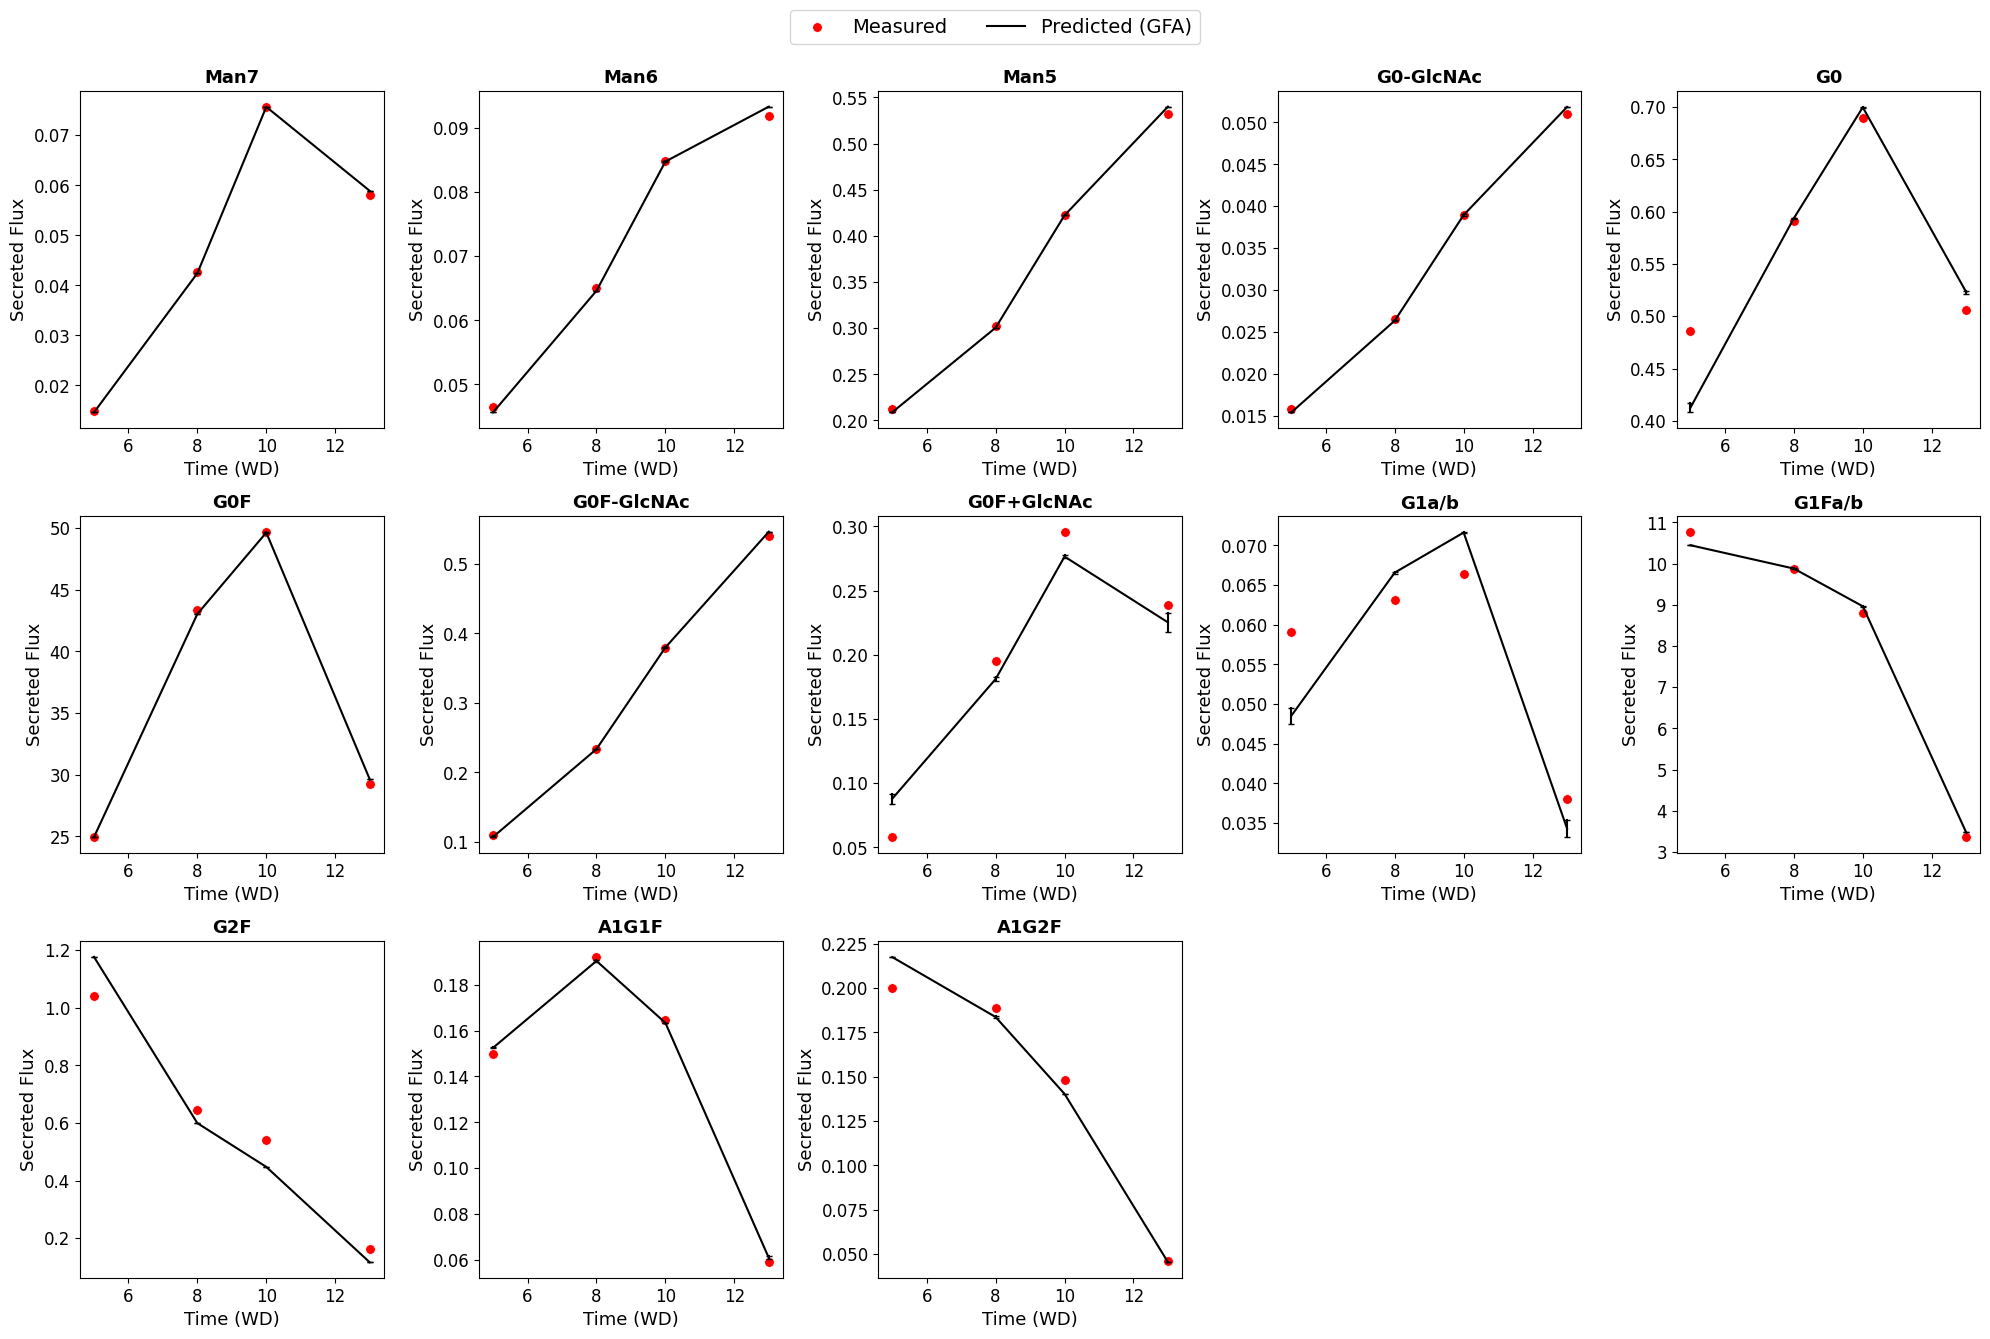

In [19]:
fig = res_data.plot_secretedflux(time_col= 'Time (WD)', meas_cols=None, ncols=5, figsize=None, res_ids=top_n_results[0:2], smooth_kwargs={'markersize': 0})

#### Alpha

{}


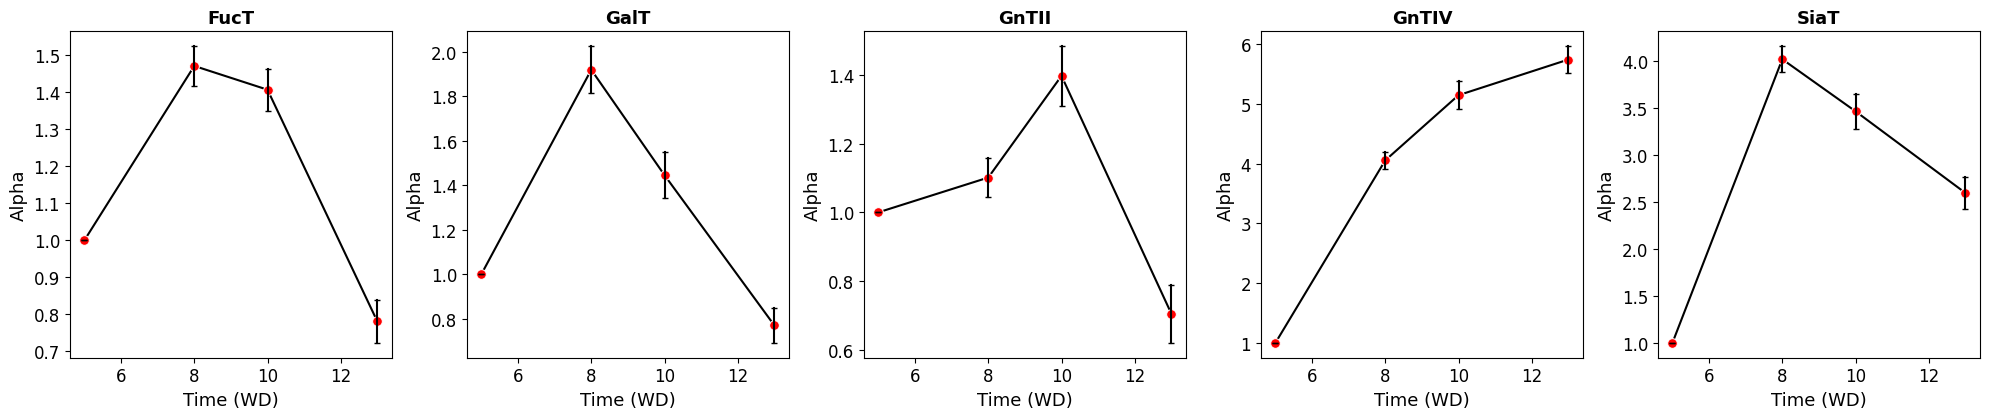

In [20]:
fig = res_data.plot_alphas(time_col='Time (WD)', meas_cols=None, ncols=5, res_ids=top_n_results, figsize=None)

#### Beta

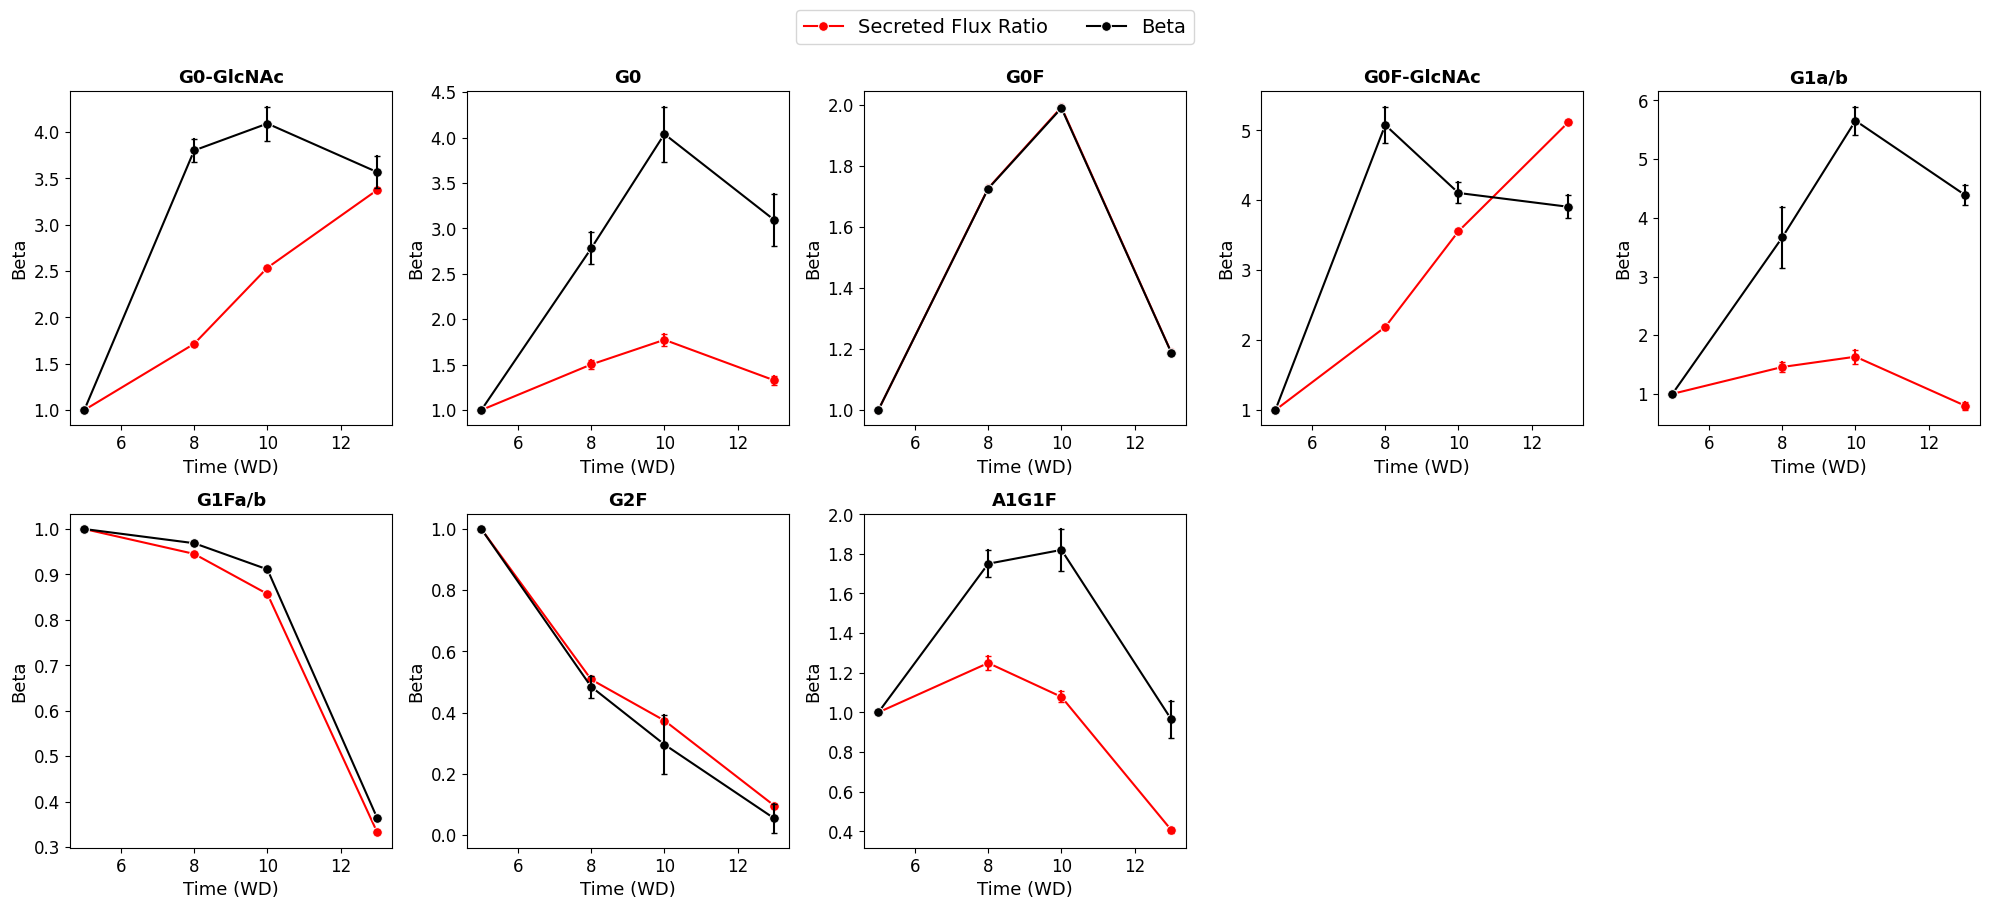

In [21]:
fig = res_data.plot_betas(time_col = 'Time (WD)', meas_cols=None, ncols=5, figsize=None, res_ids=top_n_results)

#### Gamma

{}


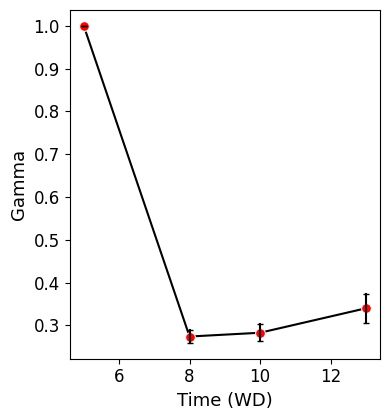

In [22]:
fig = res_data.plot_gamma(time_col = 'Time (WD)', meas_cols=None, ncols=5, figsize=None, res_ids=top_n_results)

#### Entry Flux

{}


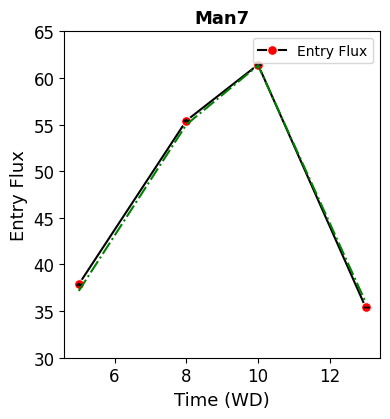

In [26]:
fig = res_data.plot_entry_flux(time_col='Time (WD)', meas_cols=None, ncols=5, figsize=None, res_ids=top_n_results)
sns.lineplot(init_model.spec_prod, x='Time (WD)', y='Spec Prod (pg/cells/day)', c='g', linestyle='-.', ax=fig.axes[0])
tick_mins = np.floor(init_model.spec_prod['Spec Prod (pg/cells/day)'].min()) - 5
tick_maxs = np.ceil(init_model.spec_prod['Spec Prod (pg/cells/day)'].max()) + 5
fig.axes[0].set_yticks(np.arange(tick_mins, tick_maxs, 5))

#### Reference Fluxes

{}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

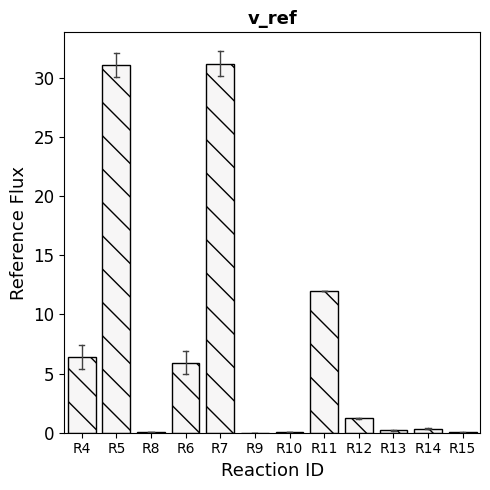

In [27]:
fig = res_data.plot_vref(x_col='Reaction ID', meas_cols=None, ncols=5, figsize=(5, 5), res_ids=top_n_results)
plt.setp(fig.axes[0].get_xticklabels(), fontsize=10)
plt.show()

#### Internal Fluxes

{}


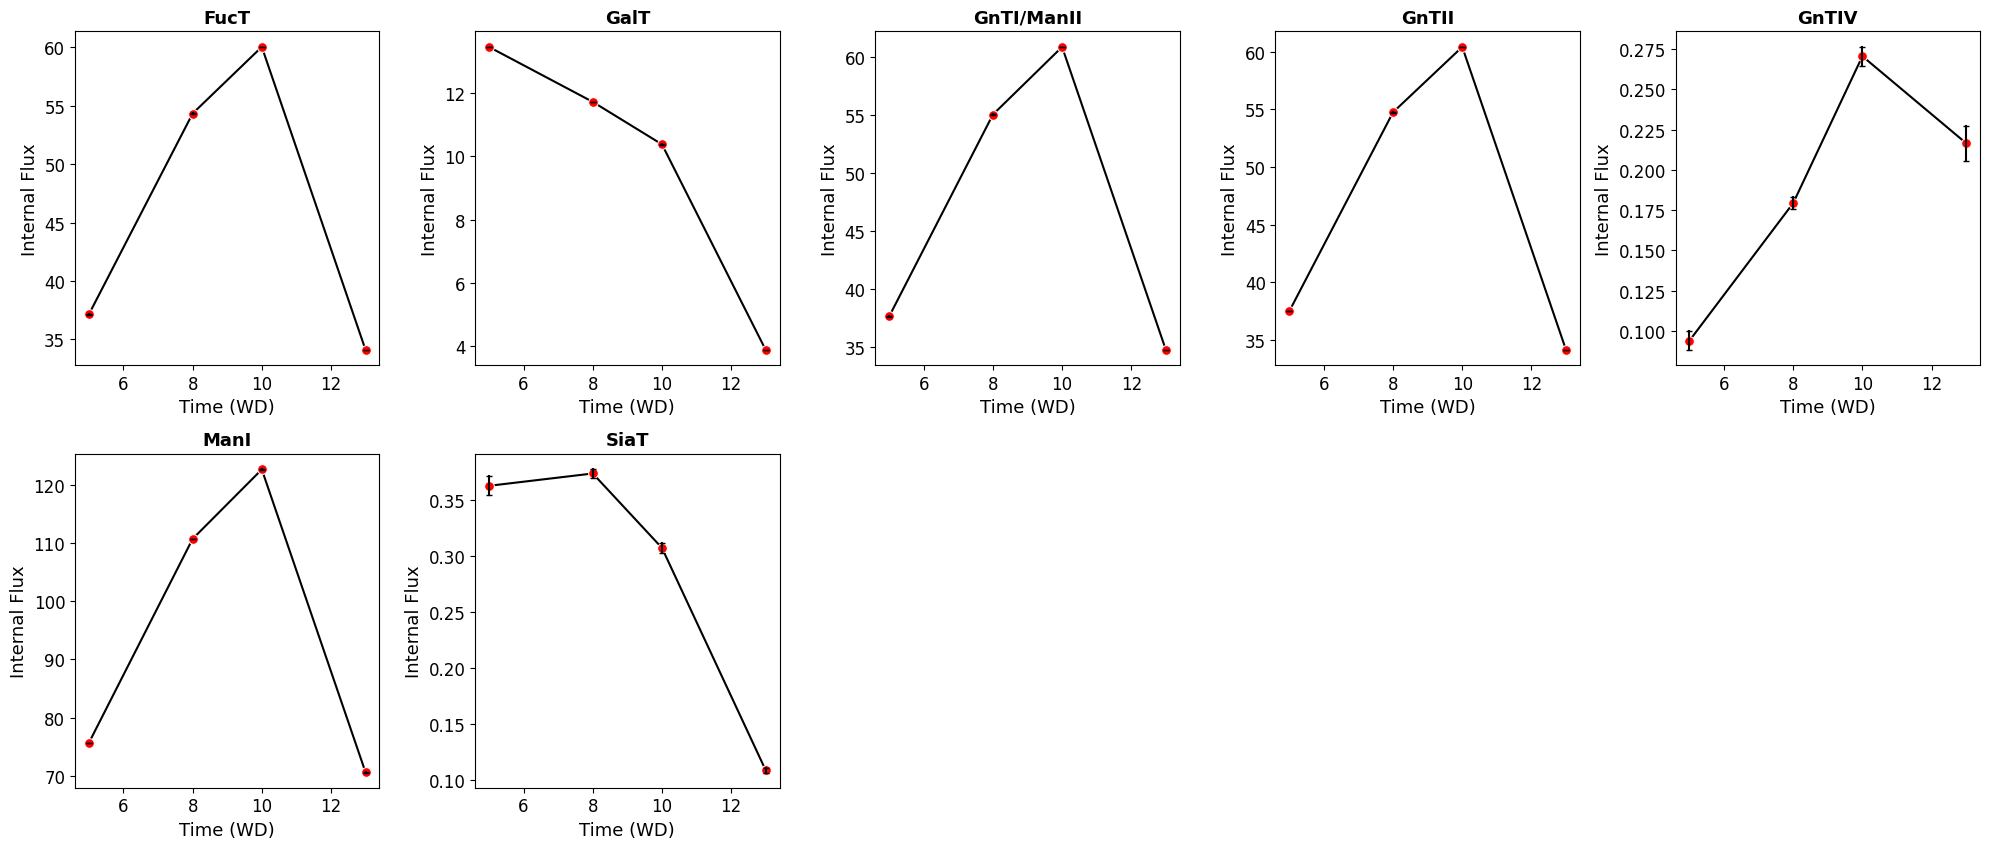

In [28]:
fig = res_data.plot_internalflux(time_col='Time (WD)', meas_cols=None, ncols=5, figsize=None, res_ids=top_n_results)